# Deepfake技術を理解する

このノートブックは、教育目的でDeepfake技術の基本概念を解説します。

## 概要

Deepfake技術は**オートエンコーダ**を使用して2人の顔を交換します。重要なポイント：

1. **共有エンコーダ**が普遍的な顔の特徴（表情、ポーズ、照明）を学習
2. **人物別デコーダ**が個々の顔を再構築する方法を学習
3. **顔交換**は、ある人の顔をエンコードし、別の人のデコーダでデコードすることで実現

In [47]:
# セットアップ
import sys
import os

# venv環境のパスを追加（VS Code Jupyter用）
venv_path = os.path.join(os.path.dirname(os.getcwd()), 'venv', 'lib', 'python3.13', 'site-packages')
if venv_path not in sys.path:
    sys.path.insert(0, venv_path)

# プロジェクトルートをパスに追加
sys.path.append('..')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# デバイスの確認
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('MPS (Metal Performance Shaders) を使用 - M4 Mac GPU')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA GPUを使用')
else:
    device = torch.device('cpu')
    print('CPUを使用')

print(f'PyTorch バージョン: {torch.__version__}')

MPS (Metal Performance Shaders) を使用 - M4 Mac GPU
PyTorch バージョン: 2.9.1


## 1. オートエンコーダとは？

オートエンコーダは以下を行うニューラルネットワークです：
1. 入力を圧縮された表現（潜在空間）に**エンコード**
2. その表現を元に戻すように**デコード**

```
入力画像 (128x128x3) → エンコーダ → 潜在空間 (4x4x128) → デコーダ → 出力 (128x128x3)
```

ネットワークは圧縮と再構築を学習し、意味のある特徴を学ぶことを強制されます。

### 軽量版と本番版の違い

| 設定 | 軽量版（本プロジェクト） | 本番版 |
|-----|----------------------|-------|
| パラメータ数 | ~670万 | ~5,000万〜2億 |
| 画像サイズ | 128×128 | 256×256〜512×512 |
| 潜在次元 | 128 | 512〜1024 |
| 学習時間/epoch | ~15秒 | ~10〜30分 |

In [36]:
# シンプルなオートエンコーダの例
class SimpleEncoder(nn.Module):
    """デモ用の簡略化されたエンコーダ"""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # 128 -> 64
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),  # 64 -> 32
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), # 32 -> 16
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.net(x)

class SimpleDecoder(nn.Module):
    """デモ用の簡略化されたデコーダ"""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 16 -> 32
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 32 -> 64
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),   # 64 -> 128
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.net(x)

# テスト
encoder = SimpleEncoder()
decoder = SimpleDecoder()

test_input = torch.randn(1, 3, 128, 128)  # 軽量版は128x128
latent = encoder(test_input)
output = decoder(latent)

print(f'入力形状: {test_input.shape}')
print(f'潜在空間形状: {latent.shape}')
print(f'出力形状: {output.shape}')
print(f'\n圧縮率: {test_input.numel() / latent.numel():.1f}倍')

入力形状: torch.Size([1, 3, 128, 128])
潜在空間形状: torch.Size([1, 128, 16, 16])
出力形状: torch.Size([1, 3, 128, 128])

圧縮率: 1.5倍


## 2. Deepfakeアーキテクチャ

Deepfakeの革新的なポイントは、**1つの共有エンコーダ**と**2つの別々のデコーダ**を使用することです：

```
人物Aの顔 ─┐
           ├─> 共有エンコーダ ─> 潜在空間 ─┬─> デコーダA ─> 再構築されたA
人物Bの顔 ─┘                              └─> デコーダB ─> 再構築されたB
```

### 学習時：
- エンコーダ + デコーダA は人物Aの顔で学習
- エンコーダ + デコーダB は人物Bの顔で学習
- エンコーダは普遍的な特徴（表情、ポーズ）を学習
- 各デコーダは人物固有の特徴（顔の形、肌の色）を学習

### 顔交換時：
- 人物Aをエンコード → 潜在表現（表情/ポーズ）を取得
- デコーダBでデコード → 人物Aの表情を持つ人物Bの顔！

In [37]:
# 実際のモデルを読み込む
from src.models import DeepfakeModel

# 軽量版モデル（128x128、潜在次元128）
model = DeepfakeModel(input_size=128, latent_dim=128).to(device)

# パラメータをカウント
encoder_params = sum(p.numel() for p in model.encoder.parameters())
decoder_a_params = sum(p.numel() for p in model.decoder_a.parameters())
decoder_b_params = sum(p.numel() for p in model.decoder_b.parameters())
total_params = sum(p.numel() for p in model.parameters())

print('=== モデルアーキテクチャ ===')
print(f'エンコーダ パラメータ: {encoder_params:,}')
print(f'デコーダA パラメータ: {decoder_a_params:,}')
print(f'デコーダB パラメータ: {decoder_b_params:,}')
print(f'合計 パラメータ: {total_params:,}')
print(f'\n注: デコーダは同じアーキテクチャなので、パラメータ数も同じ')
print(f'\n参考: 本番レベルのDeepfakeは5,000万〜2億パラメータが一般的')

=== モデルアーキテクチャ ===
エンコーダ パラメータ: 1,353,216
デコーダA パラメータ: 2,691,939
デコーダB パラメータ: 2,691,939
合計 パラメータ: 6,737,094

注: デコーダは同じアーキテクチャなので、パラメータ数も同じ

参考: 本番レベルのDeepfakeは5,000万〜2億パラメータが一般的


## 3. 潜在空間を理解する

**潜在空間**こそがマジックが起こる場所です。これは以下を捉えた圧縮表現です：
- 顔の表情とポーズ
- 人物に依存しない情報（共有エンコーダのおかげ）
- どのデコーダでもデコードでき、そのデコーダの人物の顔が得られる

イメージとしては：
- 潜在空間は「顔がどう見えるべきか」を保存（笑顔、目を開けている、頭の角度）
- 各デコーダは「この人物の顔はどう見えるか」を知っている
- 組み合わせると：「この表情の人物Bを見せて」

In [38]:
# 顔交換のコンセプトをデモ
# ダミーの「顔」画像を作成（実際には本物の顔を使用）

# 人物Aをシミュレート（顔を表すランダムパターン）
face_a = torch.rand(1, 3, 128, 128).to(device)  # 軽量版は128x128

# 人物Aの顔をエンコード
latent_a = model.encoder(face_a)
print(f'人物Aの顔を潜在空間にエンコード: {latent_a.shape}')

# デコーダAでデコード（再構築）
recon_a = model.decoder_a(latent_a)
print(f'再構築されたA（同じデコーダ）: {recon_a.shape}')

# デコーダBでデコード（顔交換！）
swap_a_to_b = model.decoder_b(latent_a)
print(f'Bに交換（別のデコーダ）: {swap_a_to_b.shape}')

print('\n=== これがDeepfakeの核心です！ ===')
print('同じ潜在コード（Aの表情） → 異なるデコーダ（Bの顔）')

人物Aの顔を潜在空間にエンコード: torch.Size([1, 128, 4, 4])
再構築されたA（同じデコーダ）: torch.Size([1, 3, 128, 128])
Bに交換（別のデコーダ）: torch.Size([1, 3, 128, 128])

=== これがDeepfakeの核心です！ ===
同じ潜在コード（Aの表情） → 異なるデコーダ（Bの顔）


## 4. 損失関数

モデルの学習には複数の損失を使用します：

### 4.1 再構築損失 (L1)
- ピクセル単位の差分
- シンプルだが効果的
- L1はL2よりシャープな画像を生成

### 4.2 知覚損失 (Perceptual Loss / VGG)
- VGGネットワークの高レベル特徴を比較
- 構造的な類似性を捉える
- 顔をより自然に見せる
- **注意**: 計算コストが高いため、軽量版ではデフォルトで無効

### 4.3 合計損失
```
L_total = λ_recon * L_recon + λ_perceptual * L_perceptual
```

| 損失関数 | 軽量版 | 本番版 |
|---------|-------|-------|
| L1 | ✓ | ✓ |
| Perceptual | - | ✓ |
| GAN | - | 推奨 |

In [39]:
from src.training.losses import ReconstructionLoss, CombinedLoss

# 損失関数を作成
recon_loss = ReconstructionLoss()

# 軽量版（L1のみ）
combined_loss_fast = CombinedLoss(use_perceptual=False).to(device)

# 品質重視版（Perceptual損失あり）
# combined_loss_quality = CombinedLoss(use_perceptual=True).to(device)

# ダミー画像でテスト
pred = torch.rand(2, 3, 128, 128).to(device)
target = torch.rand(2, 3, 128, 128).to(device)

print('=== 損失値（ランダム画像なので高い損失が予想される） ===')
print(f'再構築損失: {recon_loss(pred, target):.4f}')

losses = combined_loss_fast(pred, target)
print(f'\n合計損失（軽量版、L1のみ）:')
for k, v in losses.items():
    print(f'  {k}: {v:.4f}')

=== 損失値（ランダム画像なので高い損失が予想される） ===
再構築損失: 0.3332

合計損失（軽量版、L1のみ）:
  total: 0.3332
  recon: 0.3332
  perceptual: 0.0000


## 5. 学習プロセス

学習ループ：

```python
for epoch in range(num_epochs):
    for img_a, img_b in dataloader:
        # 順伝播
        latent_a = encoder(img_a)
        latent_b = encoder(img_b)
        recon_a = decoder_a(latent_a)
        recon_b = decoder_b(latent_b)
        
        # 損失
        loss = loss_fn(recon_a, img_a) + loss_fn(recon_b, img_b)
        
        # 逆伝播
        loss.backward()
        optimizer.step()
```

重要なポイント：
- 各バッチで両方の人物の画像を処理
- エンコーダは両方のデコーダからの勾配で更新される
- 各デコーダは自分の人物からの勾配のみを受け取る

In [40]:
# 1つの学習ステップをシミュレート
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ダミーバッチ（軽量版は128x128）
img_a = torch.rand(4, 3, 128, 128).to(device)
img_b = torch.rand(4, 3, 128, 128).to(device)

# 順伝播
recon_a, recon_b = model(img_a, img_b)

# 損失
loss_a = combined_loss_fast(recon_a, img_a)['total']
loss_b = combined_loss_fast(recon_b, img_b)['total']
total_loss = loss_a + loss_b

# 逆伝播
optimizer.zero_grad()
total_loss.backward()

# 勾配を確認
encoder_has_grad = any(p.grad is not None for p in model.encoder.parameters())
decoder_a_has_grad = any(p.grad is not None for p in model.decoder_a.parameters())

print('=== 学習ステップ完了 ===')
print(f'損失 A: {loss_a:.4f}')
print(f'損失 B: {loss_b:.4f}')
print(f'合計損失: {total_loss:.4f}')
print(f'\nエンコーダに勾配あり: {encoder_has_grad}')
print(f'デコーダAに勾配あり: {decoder_a_has_grad}')

=== 学習ステップ完了 ===
損失 A: 0.2500
損失 B: 0.2503
合計損失: 0.5003

エンコーダに勾配あり: True
デコーダAに勾配あり: True


## 6. 概念のまとめ

### 主要な概念：

1. **オートエンコーダ**: 画像を圧縮し再構築
2. **共有エンコーダ**: 普遍的な顔の特徴を学習
3. **人物別デコーダ**: 個々の顔の特徴を学習
4. **顔交換**: Aをエンコード + Bでデコード = Aの表情を持つBの顔

### なぜこれが機能するのか：

- エンコーダは両方のデコーダに役立つ特徴を学ぶことを強制される
- これらの特徴は人物に依存しない（表情、ポーズ）
- 各デコーダはこれらの特徴を特定の顔にマッピングする方法を学ぶ

---

以下のセクションでは、実際にデータ準備から顔交換テストまでを行います。

## 7. データの準備と確認

実際に顔交換を行うには、2人の顔画像が必要です。

### データ構造
```
data/
├── person_a/    # 人物Aの顔画像（500枚以上推奨）
│   ├── 001.jpg
│   ├── 002.jpg
│   └── ...
└── person_b/    # 人物Bの顔画像（500枚以上推奨）
    ├── 001.jpg
    ├── 002.jpg
    └── ...
```

### データセットの取得方法
1. **FFHQ Dataset** (Kaggle): 高品質な顔画像
2. **自分で撮影**: 同意を得た人物の顔を様々な角度で撮影
3. **動画から抽出**: ffmpegで顔フレームを抽出

In [41]:
# データディレクトリの確認
import os
from pathlib import Path
from PIL import Image
import random
from torchvision import transforms

data_a_dir = Path('../data/person_a')
data_b_dir = Path('../data/person_b')

def count_images(directory):
    """ディレクトリ内の画像数をカウント"""
    if not directory.exists():
        return 0
    extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    return len([f for f in directory.iterdir() if f.suffix.lower() in extensions])

print('=== データセット確認 ===')
print(f'人物A: {count_images(data_a_dir)} 枚')
print(f'人物B: {count_images(data_b_dir)} 枚')

if count_images(data_a_dir) == 0 or count_images(data_b_dir) == 0:
    print('\n⚠️ データがありません！')
    print('data/person_a/ と data/person_b/ に顔画像を配置してください。')
else:
    print('\n✅ データが見つかりました！')

=== データセット確認 ===
人物A: 100 枚
人物B: 100 枚

✅ データが見つかりました！
人物A: 100 枚
人物B: 100 枚

✅ データが見つかりました！


/var/folders/ss/5f9fdxxs26vdxqdz0dfmmpn00000gn/T/ipykernel_51514/2867807257.py:27: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/ss/5f9fdxxs26vdxqdz0dfmmpn00000gn/T/ipykernel_51514/2867807257.py:27: UserWarning: Glyph 29289 (\N{CJK UNIFIED IDEOGRAPH-7269}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


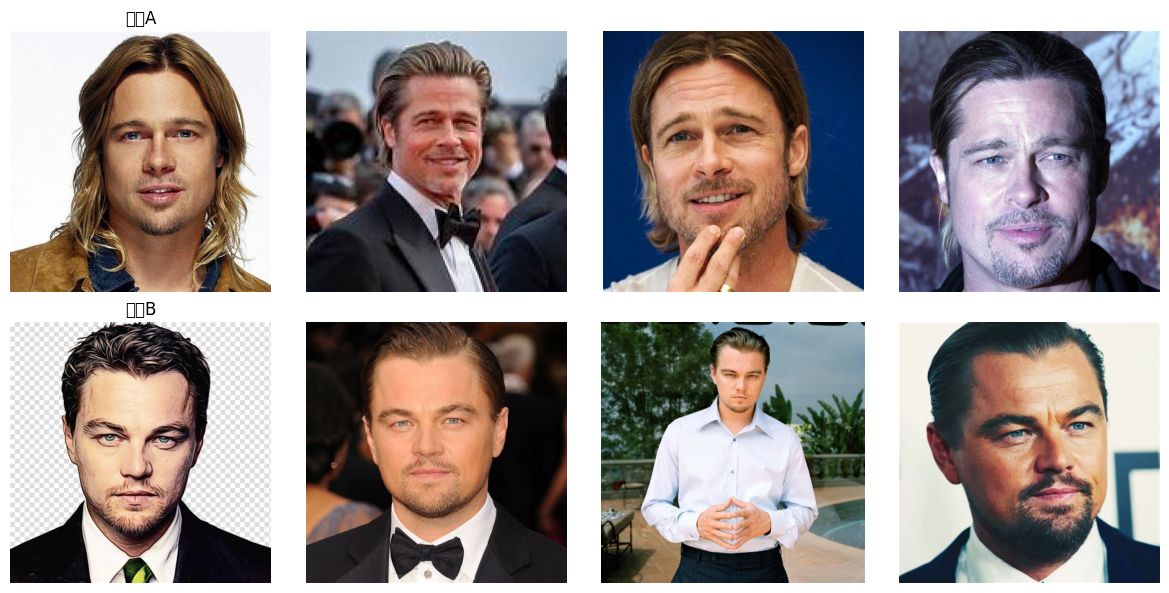

In [42]:
# サンプル画像を表示
def show_sample_images(dir_a, dir_b, num_samples=4):
    """各人物のサンプル画像を表示"""
    fig, axes = plt.subplots(2, num_samples, figsize=(3*num_samples, 6))
    
    extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    images_a = [f for f in dir_a.iterdir() if f.suffix.lower() in extensions]
    images_b = [f for f in dir_b.iterdir() if f.suffix.lower() in extensions]
    
    samples_a = random.sample(images_a, min(num_samples, len(images_a)))
    samples_b = random.sample(images_b, min(num_samples, len(images_b)))
    
    for i, img_path in enumerate(samples_a):
        img = Image.open(img_path).convert('RGB')
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('人物A', fontsize=12)
    
    for i, img_path in enumerate(samples_b):
        img = Image.open(img_path).convert('RGB')
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('人物B', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# データがあれば表示
if count_images(data_a_dir) > 0 and count_images(data_b_dir) > 0:
    show_sample_images(data_a_dir, data_b_dir)
else:
    print('データを配置後、このセルを再実行してください。')

## 8. モデルの学習

ノートブック内で学習を実行できます。ただし、長時間の学習はターミナルで実行することを推奨します。

### ターミナルでの実行（推奨）
```bash
# 軽量版（高速、教育用）
python train.py --data-a data/person_a --data-b data/person_b --epochs 50

# 品質重視版（Perceptual Loss有効）
python train.py --data-a data/person_a --data-b data/person_b --epochs 200 --perceptual
```

### ノートブック内での学習
以下のセルで短いデモ学習を実行できます。

In [43]:
# ノートブック内での短い学習（デモ用、5エポック）
from src.data import create_dataloaders
from src.training import DeepfakeTrainer

# データがあるか確認
if count_images(data_a_dir) == 0 or count_images(data_b_dir) == 0:
    print('❌ データがありません。先にデータを準備してください。')
else:
    print('=== 短いデモ学習（5エポック） ===')
    print('注意: 本格的な学習はターミナルで実行してください。\n')
    
    # データローダー作成
    train_loader, val_loader = create_dataloaders(
        dir_a=str(data_a_dir),
        dir_b=str(data_b_dir),
        batch_size=8,
        image_size=128,
        num_workers=0,
    )
    
    # モデル作成
    demo_model = DeepfakeModel(input_size=128, latent_dim=128)
    
    # トレーナー作成（一時ディレクトリに保存）
    demo_trainer = DeepfakeTrainer(
        model=demo_model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        checkpoint_dir='../checkpoints_demo',
        log_dir='../runs_demo',
        learning_rate=1e-4,
        use_perceptual=False,
    )
    
    # 5エポックだけ学習
    demo_trainer.train(num_epochs=5)
    print('\n✅ デモ学習完了！')

=== 短いデモ学習（5エポック） ===
注意: 本格的な学習はターミナルで実行してください。

DeepfakeDataset initialized:
  Person A: 100 images
  Person B: 100 images
DeepfakeDataset initialized:
  Person A: 100 images
  Person B: 100 images
Training on: mps
Using L1 loss only (fast mode)

Starting training for 5 epochs
Device: mps



Epoch 0: 100%|██████████| 125/125 [00:20<00:00,  6.06it/s, loss=0.436, recon=0.436]



Epoch 0 - Train Loss: 0.5437
Epoch 0 - Val Loss: 0.4257
  Saved best model (val_loss: 0.4257)


Epoch 1: 100%|██████████| 125/125 [00:20<00:00,  6.09it/s, loss=0.325, recon=0.325]



Epoch 1 - Train Loss: 0.3706
Epoch 1 - Val Loss: 0.3212


Epoch 2: 100%|██████████| 125/125 [00:20<00:00,  6.14it/s, loss=0.315, recon=0.315]



Epoch 2 - Train Loss: 0.3191
Epoch 2 - Val Loss: 0.2951


Epoch 3: 100%|██████████| 125/125 [00:20<00:00,  6.19it/s, loss=0.291, recon=0.291]



Epoch 3 - Train Loss: 0.2912
Epoch 3 - Val Loss: 0.2658


Epoch 4: 100%|██████████| 125/125 [00:20<00:00,  6.06it/s, loss=0.265, recon=0.265]



Epoch 4 - Train Loss: 0.2669
Epoch 4 - Val Loss: 0.2571

Training complete!

✅ デモ学習完了！


## 9. 顔交換テスト

学習済みモデルを使って、実際に顔交換を行います。

### チェックポイントの場所
- `checkpoints/best.pt` - 最も良いモデル（Val Loss基準）
- `checkpoints/latest.pt` - 最新のモデル

In [48]:
# 学習済みモデルの読み込み
from pathlib import Path

#checkpoint_path = Path('../checkpoints_demo/best.pt')
checkpoint_path = Path('../checkpoints/best.pt')

if not checkpoint_path.exists():
    print('❌ 学習済みモデルが見つかりません。')
    print('先に学習を実行してください：')
    print('  python train.py --data-a data/person_a --data-b data/person_b')
else:
    # モデル作成と重みの読み込み
    swap_model = DeepfakeModel(input_size=128, latent_dim=128)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    swap_model.load_state_dict(checkpoint['model_state_dict'])
    swap_model.to(device)
    swap_model.eval()
    
    print('✅ モデル読み込み完了')
    print(f"  エポック: {checkpoint.get('epoch', 'N/A')}")
    val_loss = checkpoint.get('val_loss', checkpoint.get('loss', 'N/A'))
    if isinstance(val_loss, (int, float)):
        print(f"  損失: {val_loss:.4f}")
    else:
        print(f"  損失: {val_loss}")

✅ モデル読み込み完了
  エポック: 70
  損失: N/A


Using images:
  Person A: 009_23c94f29.jpg
  Person B: 008_35daa4bc.jpg



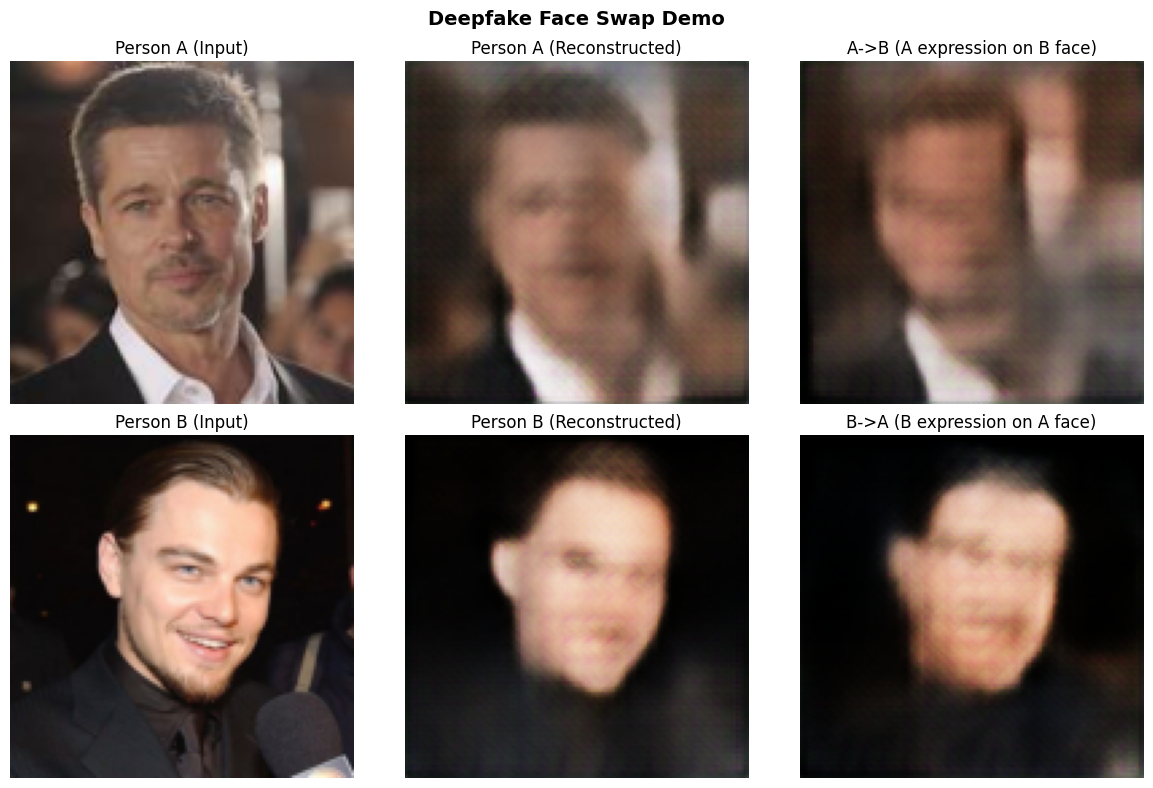

In [49]:
# 顔交換を実行して可視化
def load_image_tensor(image_path, size=128):
    """画像をテンソルに変換"""
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    img = Image.open(image_path).convert('RGB')
    return transform(img).unsqueeze(0)

def tensor_to_image(tensor):
    """テンソルをPIL画像に変換"""
    img = tensor.squeeze(0).cpu().detach()
    img = img.clamp(0, 1)
    img = img.permute(1, 2, 0).numpy()
    return Image.fromarray((img * 255).astype('uint8'))

def visualize_face_swap(model, img_a_path, img_b_path, device):
    """顔交換の結果を可視化"""
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    with torch.no_grad():
        # 画像読み込み
        img_a = load_image_tensor(img_a_path).to(device)
        img_b = load_image_tensor(img_b_path).to(device)
        
        # モデルで処理
        outputs = model.get_training_outputs(img_a, img_b)
        
        # 上段: 人物A
        axes[0, 0].imshow(tensor_to_image(img_a))
        axes[0, 0].set_title('Person A (Input)')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(tensor_to_image(outputs['recon_a']))
        axes[0, 1].set_title('Person A (Reconstructed)')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(tensor_to_image(outputs['swap_a_to_b']))
        axes[0, 2].set_title('A->B (A expression on B face)')
        axes[0, 2].axis('off')
        
        # 下段: 人物B
        axes[1, 0].imshow(tensor_to_image(img_b))
        axes[1, 0].set_title('Person B (Input)')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(tensor_to_image(outputs['recon_b']))
        axes[1, 1].set_title('Person B (Reconstructed)')
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(tensor_to_image(outputs['swap_b_to_a']))
        axes[1, 2].set_title('B->A (B expression on A face)')
        axes[1, 2].axis('off')
    
    plt.suptitle('Deepfake Face Swap Demo', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# モデルとデータがあれば実行
if checkpoint_path.exists() and count_images(data_a_dir) > 0:
    # ランダムな画像を選択
    extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    images_a = [f for f in data_a_dir.iterdir() if f.suffix.lower() in extensions]
    images_b = [f for f in data_b_dir.iterdir() if f.suffix.lower() in extensions]
    
    img_a_path = random.choice(images_a)
    img_b_path = random.choice(images_b)
    
    print(f'Using images:')
    print(f'  Person A: {img_a_path.name}')
    print(f'  Person B: {img_b_path.name}')
    print()
    
    visualize_face_swap(swap_model, str(img_a_path), str(img_b_path), device)
else:
    print('Prepare model and data, then re-run this cell.')

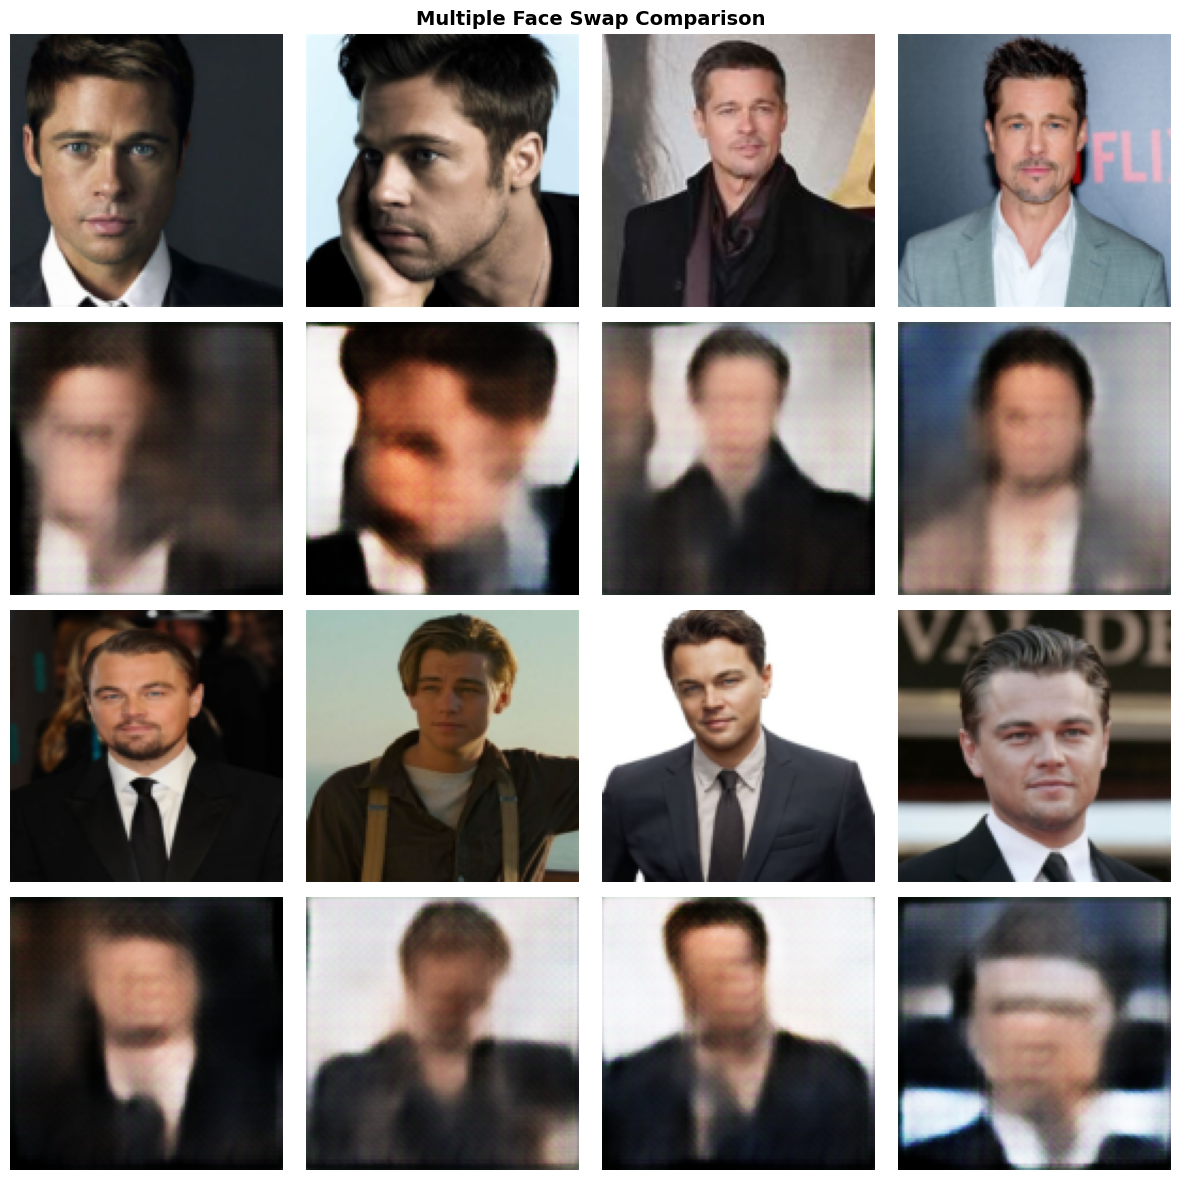

In [50]:
# 複数のサンプルで顔交換を比較
def visualize_multiple_swaps(model, dir_a, dir_b, device, num_samples=4):
    """複数の画像ペアで顔交換を比較"""
    extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    images_a = [f for f in dir_a.iterdir() if f.suffix.lower() in extensions]
    images_b = [f for f in dir_b.iterdir() if f.suffix.lower() in extensions]
    
    samples_a = random.sample(images_a, min(num_samples, len(images_a)))
    samples_b = random.sample(images_b, min(num_samples, len(images_b)))
    
    fig, axes = plt.subplots(4, num_samples, figsize=(3*num_samples, 12))
    
    row_labels = ['Person A (Input)', 'A->B Swap', 'Person B (Input)', 'B->A Swap']
    
    with torch.no_grad():
        for i in range(num_samples):
            img_a = load_image_tensor(str(samples_a[i])).to(device)
            img_b = load_image_tensor(str(samples_b[i])).to(device)
            outputs = model.get_training_outputs(img_a, img_b)
            
            results = [
                img_a,
                outputs['swap_a_to_b'],
                img_b,
                outputs['swap_b_to_a'],
            ]
            
            for row, tensor in enumerate(results):
                axes[row, i].imshow(tensor_to_image(tensor))
                axes[row, i].axis('off')
                if i == 0:
                    axes[row, i].set_ylabel(row_labels[row], fontsize=10, 
                                           rotation=0, labelpad=70, ha='right')
    
    plt.suptitle('Multiple Face Swap Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# モデルとデータがあれば実行
if checkpoint_path.exists() and count_images(data_a_dir) > 0:
    visualize_multiple_swaps(swap_model, data_a_dir, data_b_dir, device, num_samples=4)
else:
    print('Prepare model and data, then re-run this cell.')

## 10. まとめと次のステップ

### このノートブックで学んだこと

| セクション | 内容 |
|-----------|------|
| 1-6 | Deepfake技術の概念理解 |
| 7 | データの準備と確認 |
| 8 | モデルの学習（デモ/本格） |
| 9 | 顔交換テストと可視化 |

### 品質改善のヒント

1. **より多くのデータ**: 各人物1000枚以上で品質向上
2. **Perceptual Loss**: `--perceptual`オプションで構造的類似性を改善
3. **より長い学習**: 200エポック以上で収束
4. **高解像度**: `--image-size 256`で細部を表現（遅くなる）

### 参考コマンド

```bash
# 高品質学習（推奨）
python train.py --data-a data/person_a --data-b data/person_b \
    --epochs 200 --perceptual --batch-size 8

# TensorBoardで学習監視
tensorboard --logdir runs

# 顔交換デモ実行
python demo_swap.py
```

### 倫理的注意

- ✅ 教育・研究目的のみ使用
- ✅ 同意を得た人物の画像のみ使用
- ❌ なりすまし・詐欺行為は厳禁
- ❌ 他人を傷つける目的での使用禁止